In [9]:
import os
import sys
os.chdir("/content/drive/MyDrive/MasterStudy/mask_rcnn")
sys.path.append('/content/drive/MyDrive/MasterStudy/mask_rcnn')


In [10]:
import os
import numpy as np
from tqdm import tqdm
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.transforms import functional as F
from PIL import Image, ImageDraw
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score
import warnings
warnings.filterwarnings("ignore")

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation_file, transforms=None):
        self.root = root
        self.transforms = transforms
        with open(annotation_file) as f:
            self.coco = json.load(f)
        self.images = self.coco['images']
        self.annotations = self.coco['annotations']
        self.image_id_to_annotations = {image['id']: [] for image in self.images}
        for annotation in self.annotations:
            self.image_id_to_annotations[annotation['image_id']].append(annotation)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = os.path.join(self.root, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")
        annotations = self.image_id_to_annotations[img_info['id']]

        boxes = []
        labels = []
        masks = []
        for annotation in annotations:
            xmin = annotation['bbox'][0]
            ymin = annotation['bbox'][1]
            xmax = xmin + annotation['bbox'][2]
            ymax = ymin + annotation['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(annotation['category_id'])

            # Create a mask for the current annotation
            mask = Image.new('1', (img_info['width'], img_info['height']))
            draw = ImageDraw.Draw(mask)
            for segmentation in annotation['segmentation']:
                if isinstance(segmentation, list):  # Check if segmentation is a list of lists
                    poly = np.array(segmentation).reshape((-1, 2))
                    draw.polygon([tuple(p) for p in poly], outline=1, fill=1)
            masks.append(mask)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.stack([torch.tensor(np.array(mask), dtype=torch.uint8) for mask in masks])

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['masks'] = masks

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.images)

def collate_fn(batch):
    return tuple(zip(*batch))

def get_model(num_classes):
    weights = MaskRCNN_ResNet50_FPN_Weights.COCO_V1
    model = maskrcnn_resnet50_fpn(weights=weights)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    return model

def evaluate_model(model, data_loader, device):
    model.train()
    total_loss = 0
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()
    return total_loss / len(data_loader)

def train_model(model, train_loader, val_loader, optimizer, device, num_epochs, save_path):
    best_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", ncols=100)
        for images, targets in progress_bar:
            try:
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                optimizer.zero_grad()
                losses.backward()
                optimizer.step()
                running_loss += losses.item()
                progress_bar.set_postfix(loss=running_loss / (progress_bar.n + 1))
            except Exception as e:
                print(f"Error processing batch: {e}")
                raise e
        print(f"Epoch: {epoch + 1}, Training Loss: {running_loss / len(train_loader)}")

        val_loss = evaluate_model(model, val_loader, device)
        print(f"Epoch: {epoch + 1}, Validation Loss: {val_loss}")

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Model saved with validation loss: {val_loss}")

def compute_iou(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    if union == 0:
        return 0.0
    return intersection / union

def compute_metrics(model, data_loader, device, iou_thresholds=[0.5, 0.75]):
    model.eval()
    all_precisions = {iou: [] for iou in iou_thresholds}
    all_recalls = {iou: [] for iou in iou_thresholds}
    all_aps = {iou: [] for iou in iou_thresholds}
    all_map50_95 = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            outputs = model(images)

            for target, output in zip(targets, outputs):
                gt_masks = target['masks'].cpu().numpy()
                pred_masks = output['masks'].cpu().numpy()
                pred_scores = output['scores'].cpu().numpy()

                for iou_threshold in iou_thresholds:
                    ious = [compute_iou(pred_mask > 0.5, gt_mask > 0.5) for pred_mask, gt_mask in zip(pred_masks, gt_masks)]
                    tp = np.sum(np.array(ious) >= iou_threshold)
                    fp = np.sum(np.array(ious) < iou_threshold)
                    fn = len(gt_masks) - tp
                    precision = tp / (tp + fp) if tp + fp > 0 else 0
                    recall = tp / (tp + fn) if tp + fn > 0 else 0
                    all_precisions[iou_threshold].append(precision)
                    all_recalls[iou_threshold].append(recall)

                    if tp + fp > 0:
                        ap = average_precision_score([1] * tp + [0] * fp, pred_scores[:tp + fp])
                        all_aps[iou_threshold].append(ap)

                if tp + fp > 0:
                    map50_95 = average_precision_score([1] * tp + [0] * fp, pred_scores[:tp + fp])
                    all_map50_95.append(map50_95)

    # Calculate the mean of each metric
    mean_precisions = {iou: np.mean(all_precisions[iou]) for iou in iou_thresholds if len(all_precisions[iou]) > 0}
    mean_recalls = {iou: np.mean(all_recalls[iou]) for iou in iou_thresholds if len(all_recalls[iou]) > 0}
    mean_aps = {iou: np.mean(all_aps[iou]) for iou in iou_thresholds if len(all_aps[iou]) > 0}
    mean_map50_95 = np.mean(all_map50_95) if len(all_map50_95) > 0 else 0

    return mean_precisions, mean_recalls, mean_aps, mean_map50_95

if __name__ == "__main__":
    dataset = CustomDataset(root="train", annotation_file="train/annotations.coco.json",
                            transforms=torchvision.transforms.ToTensor())

    train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=64)
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    test_dataset = torch.utils.data.Subset(dataset, test_indices)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=collate_fn)
    val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0, collate_fn=collate_fn)

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    model = get_model(num_classes=4)  # Adjust number of classes based on your dataset
    model.to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=0.0005)

    save_path = "mask_rcnn_model.pth"
    train_model(model, train_loader, val_loader, optimizer, device, num_epochs=100, save_path=save_path)

    mean_precisions, mean_recalls, mean_aps, mean_map50_95 = compute_metrics(model, val_loader, device)

    print(f"Precision at IOU thresholds: {mean_precisions}")
    print(f"Recall at IOU thresholds: {mean_recalls}")
    print(f"Average Precision at IOU thresholds: {mean_aps}")
    print(f"mAP50-95: {mean_map50_95}")


Epoch 1/100: 100%|██████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.647]


Epoch: 1, Training Loss: 0.6471891469425626
Epoch: 1, Validation Loss: 0.42060178766647977
Model saved with validation loss: 0.42060178766647977


Epoch 2/100: 100%|██████████████████████████████████████| 45/45 [01:19<00:00,  1.76s/it, loss=0.263]


Epoch: 2, Training Loss: 0.26284473571512434
Epoch: 2, Validation Loss: 0.3455693759024143
Model saved with validation loss: 0.3455693759024143


Epoch 3/100: 100%|██████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.201]


Epoch: 3, Training Loss: 0.20131475064489576
Epoch: 3, Validation Loss: 0.3074638731777668
Model saved with validation loss: 0.3074638731777668


Epoch 4/100: 100%|██████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.163]


Epoch: 4, Training Loss: 0.1634645170635647
Epoch: 4, Validation Loss: 0.2838421203196049
Model saved with validation loss: 0.2838421203196049


Epoch 5/100: 100%|██████████████████████████████████████| 45/45 [01:19<00:00,  1.76s/it, loss=0.148]


Epoch: 5, Training Loss: 0.14778095616234674
Epoch: 5, Validation Loss: 0.2734509129077196
Model saved with validation loss: 0.2734509129077196


Epoch 6/100: 100%|██████████████████████████████████████| 45/45 [01:18<00:00,  1.76s/it, loss=0.137]


Epoch: 6, Training Loss: 0.1373039820128017
Epoch: 6, Validation Loss: 0.2723665690670411
Model saved with validation loss: 0.2723665690670411


Epoch 7/100: 100%|██████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.131]


Epoch: 7, Training Loss: 0.13090248737070295
Epoch: 7, Validation Loss: 0.26790611383815605
Model saved with validation loss: 0.26790611383815605


Epoch 8/100: 100%|██████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.121]


Epoch: 8, Training Loss: 0.12138393736547894
Epoch: 8, Validation Loss: 0.2662542077402274
Model saved with validation loss: 0.2662542077402274


Epoch 9/100: 100%|██████████████████████████████████████| 45/45 [01:19<00:00,  1.76s/it, loss=0.117]


Epoch: 9, Training Loss: 0.11686770485507117
Epoch: 9, Validation Loss: 0.2642193033049504
Model saved with validation loss: 0.2642193033049504


Epoch 10/100: 100%|█████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.113]


Epoch: 10, Training Loss: 0.11250621047284869
Epoch: 10, Validation Loss: 0.2602695431560278
Model saved with validation loss: 0.2602695431560278


Epoch 11/100: 100%|█████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.111]


Epoch: 11, Training Loss: 0.11086246255371306
Epoch: 11, Validation Loss: 0.25565741832057637
Model saved with validation loss: 0.25565741832057637


Epoch 12/100: 100%|█████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.106]


Epoch: 12, Training Loss: 0.10615684688091279
Epoch: 12, Validation Loss: 0.2601393684744835


Epoch 13/100: 100%|█████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.105]


Epoch: 13, Training Loss: 0.10466309984525045
Epoch: 13, Validation Loss: 0.2571620376159747


Epoch 14/100: 100%|███████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.1]


Epoch: 14, Training Loss: 0.10026053736607234
Epoch: 14, Validation Loss: 0.2631201781332493


Epoch 15/100: 100%|█████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.104]


Epoch: 15, Training Loss: 0.10444516191879909
Epoch: 15, Validation Loss: 0.26276807859539986


Epoch 16/100: 100%|█████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.102]


Epoch: 16, Training Loss: 0.10169980658425225
Epoch: 16, Validation Loss: 0.27065311434368294


Epoch 17/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0976]


Epoch: 17, Training Loss: 0.09757827007108265
Epoch: 17, Validation Loss: 0.2648996238907178


Epoch 18/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0944]


Epoch: 18, Training Loss: 0.09442235694991218
Epoch: 18, Validation Loss: 0.25841361470520496


Epoch 19/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0943]


Epoch: 19, Training Loss: 0.09432169728808933
Epoch: 19, Validation Loss: 0.28160477615892887


Epoch 20/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0976]


Epoch: 20, Training Loss: 0.09764863087071313
Epoch: 20, Validation Loss: 0.26037714009483653


Epoch 21/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.74s/it, loss=0.0904]


Epoch: 21, Training Loss: 0.09038737846745384
Epoch: 21, Validation Loss: 0.2637507983793815


Epoch 22/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.74s/it, loss=0.0895]


Epoch: 22, Training Loss: 0.08945669333140055
Epoch: 22, Validation Loss: 0.25994184985756874


Epoch 23/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.74s/it, loss=0.0917]


Epoch: 23, Training Loss: 0.09173573123084175
Epoch: 23, Validation Loss: 0.267336326961716


Epoch 24/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0901]


Epoch: 24, Training Loss: 0.09014955394797855
Epoch: 24, Validation Loss: 0.26556493528187275


Epoch 25/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0872]


Epoch: 25, Training Loss: 0.08722342169947095
Epoch: 25, Validation Loss: 0.2648553717881441


Epoch 26/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0869]


Epoch: 26, Training Loss: 0.0869231136308776
Epoch: 26, Validation Loss: 0.26066387568910915


Epoch 27/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0856]


Epoch: 27, Training Loss: 0.08563107334905201
Epoch: 27, Validation Loss: 0.26377123532195884


Epoch 28/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.74s/it, loss=0.0847]


Epoch: 28, Training Loss: 0.08470465143521627
Epoch: 28, Validation Loss: 0.26758079044520855


Epoch 29/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.74s/it, loss=0.0836]


Epoch: 29, Training Loss: 0.08362009194162157
Epoch: 29, Validation Loss: 0.26724453332523507


Epoch 30/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.74s/it, loss=0.0828]


Epoch: 30, Training Loss: 0.08284880369901657
Epoch: 30, Validation Loss: 0.25924138724803925


Epoch 31/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.74s/it, loss=0.0827]


Epoch: 31, Training Loss: 0.08267296055952708
Epoch: 31, Validation Loss: 0.2606811535855134


Epoch 32/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0835]


Epoch: 32, Training Loss: 0.08348306135998831
Epoch: 32, Validation Loss: 0.2708112522959709


Epoch 33/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.74s/it, loss=0.0819]


Epoch: 33, Training Loss: 0.08194192283683353
Epoch: 33, Validation Loss: 0.26256492796043557


Epoch 34/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.74s/it, loss=0.0828]


Epoch: 34, Training Loss: 0.08278609017531077
Epoch: 34, Validation Loss: 0.26650957639018696


Epoch 35/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.74s/it, loss=0.0804]


Epoch: 35, Training Loss: 0.0804449020160569
Epoch: 35, Validation Loss: 0.26729742002983886


Epoch 36/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.74s/it, loss=0.0829]


Epoch: 36, Training Loss: 0.08292568971713384
Epoch: 36, Validation Loss: 0.25967256414393586


Epoch 37/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0866]


Epoch: 37, Training Loss: 0.08663889997535282
Epoch: 37, Validation Loss: 0.26204972838362056


Epoch 38/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.74s/it, loss=0.0819]


Epoch: 38, Training Loss: 0.08190071996715334
Epoch: 38, Validation Loss: 0.2673545107245445


Epoch 39/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0782]


Epoch: 39, Training Loss: 0.07815544009208679
Epoch: 39, Validation Loss: 0.26683903113007545


Epoch 40/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.74s/it, loss=0.0789]


Epoch: 40, Training Loss: 0.07890968140628603
Epoch: 40, Validation Loss: 0.2619124340514342


Epoch 41/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0786]


Epoch: 41, Training Loss: 0.07863364236222373
Epoch: 41, Validation Loss: 0.2600651240597169


Epoch 42/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.76s/it, loss=0.0772]


Epoch: 42, Training Loss: 0.07720088710387547
Epoch: 42, Validation Loss: 0.2618338546405236


Epoch 43/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0775]


Epoch: 43, Training Loss: 0.07752583838171428
Epoch: 43, Validation Loss: 0.267153512686491


Epoch 44/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0765]


Epoch: 44, Training Loss: 0.07652456164360047
Epoch: 44, Validation Loss: 0.27228720237811405


Epoch 45/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0787]


Epoch: 45, Training Loss: 0.07868993398216036
Epoch: 45, Validation Loss: 0.2687978570659955


Epoch 46/100: 100%|████████████████████████████████████| 45/45 [01:19<00:00,  1.76s/it, loss=0.0759]


Epoch: 46, Training Loss: 0.07591601411501567
Epoch: 46, Validation Loss: 0.2634583208709955


Epoch 47/100: 100%|████████████████████████████████████| 45/45 [01:19<00:00,  1.76s/it, loss=0.0759]


Epoch: 47, Training Loss: 0.07589887347486284
Epoch: 47, Validation Loss: 0.2692521022011836


Epoch 48/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0747]


Epoch: 48, Training Loss: 0.07473346392313639
Epoch: 48, Validation Loss: 0.25960660601655644


Epoch 49/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0746]


Epoch: 49, Training Loss: 0.0746273320582178
Epoch: 49, Validation Loss: 0.2605707539866368


Epoch 50/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0772]


Epoch: 50, Training Loss: 0.07720949550469716
Epoch: 50, Validation Loss: 0.2646567753205697


Epoch 51/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0768]


Epoch: 51, Training Loss: 0.07675392826398214
Epoch: 51, Validation Loss: 0.2604330386966467


Epoch 52/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0758]


Epoch: 52, Training Loss: 0.07580571621656418
Epoch: 52, Validation Loss: 0.2628534560402234


Epoch 53/100: 100%|█████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.076]


Epoch: 53, Training Loss: 0.07601056082381143
Epoch: 53, Validation Loss: 0.2572406592468421


Epoch 54/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0756]


Epoch: 54, Training Loss: 0.0755519535806444
Epoch: 54, Validation Loss: 0.25970972205201787


Epoch 55/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0739]


Epoch: 55, Training Loss: 0.07386037823226717
Epoch: 55, Validation Loss: 0.26598515920341015


Epoch 56/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0742]


Epoch: 56, Training Loss: 0.07417079872555203
Epoch: 56, Validation Loss: 0.2616111636161804


Epoch 57/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0827]


Epoch: 57, Training Loss: 0.08266109244691001
Epoch: 57, Validation Loss: 0.2653516723463933


Epoch 58/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0757]


Epoch: 58, Training Loss: 0.07566560291581684
Epoch: 58, Validation Loss: 0.2578292029599349


Epoch 59/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0732]


Epoch: 59, Training Loss: 0.0731748787065347
Epoch: 59, Validation Loss: 0.2692600004374981


Epoch 60/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0726]


Epoch: 60, Training Loss: 0.07255740703807936
Epoch: 60, Validation Loss: 0.2634331379085779


Epoch 61/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0725]


Epoch: 61, Training Loss: 0.07248250146706899
Epoch: 61, Validation Loss: 0.2609561501691739


Epoch 62/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0721]


Epoch: 62, Training Loss: 0.07211634847852919
Epoch: 62, Validation Loss: 0.26147006389995414


Epoch 63/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0756]


Epoch: 63, Training Loss: 0.07560753673315049
Epoch: 63, Validation Loss: 0.2662903927266598


Epoch 64/100: 100%|█████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.073]


Epoch: 64, Training Loss: 0.07297768352760209
Epoch: 64, Validation Loss: 0.2614577002823353


Epoch 65/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0723]


Epoch: 65, Training Loss: 0.07228593197133806
Epoch: 65, Validation Loss: 0.2615794812639554


Epoch 66/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0761]


Epoch: 66, Training Loss: 0.07609956496291691
Epoch: 66, Validation Loss: 0.2638834460328023


Epoch 67/100: 100%|█████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.077]


Epoch: 67, Training Loss: 0.07703232516845067
Epoch: 67, Validation Loss: 0.26013233823080856


Epoch 68/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0729]


Epoch: 68, Training Loss: 0.07288319203588697
Epoch: 68, Validation Loss: 0.2545540959884723
Model saved with validation loss: 0.2545540959884723


Epoch 69/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0713]


Epoch: 69, Training Loss: 0.07127487162748973
Epoch: 69, Validation Loss: 0.2604262127230565


Epoch 70/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.74s/it, loss=0.0718]


Epoch: 70, Training Loss: 0.07184607477651703
Epoch: 70, Validation Loss: 0.25959701649844646


Epoch 71/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0712]


Epoch: 71, Training Loss: 0.07121272219551934
Epoch: 71, Validation Loss: 0.2629497131953637


Epoch 72/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0732]


Epoch: 72, Training Loss: 0.07321475272377333
Epoch: 72, Validation Loss: 0.25302550941705704
Model saved with validation loss: 0.25302550941705704


Epoch 73/100: 100%|████████████████████████████████████| 45/45 [01:19<00:00,  1.77s/it, loss=0.0767]


Epoch: 73, Training Loss: 0.07667256063885158
Epoch: 73, Validation Loss: 0.2602229068676631


Epoch 74/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0735]


Epoch: 74, Training Loss: 0.07354237818055682
Epoch: 74, Validation Loss: 0.2589348703622818


Epoch 75/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0711]


Epoch: 75, Training Loss: 0.07114026803109381
Epoch: 75, Validation Loss: 0.2590280243506034


Epoch 76/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.74s/it, loss=0.0704]


Epoch: 76, Training Loss: 0.07037338904208607
Epoch: 76, Validation Loss: 0.25291313727696735
Model saved with validation loss: 0.25291313727696735


Epoch 77/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0716]


Epoch: 77, Training Loss: 0.07159225982096461
Epoch: 77, Validation Loss: 0.2563307595749696


Epoch 78/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.74s/it, loss=0.0708]


Epoch: 78, Training Loss: 0.07077215106950865
Epoch: 78, Validation Loss: 0.26122161249319714


Epoch 79/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.74s/it, loss=0.0702]


Epoch: 79, Training Loss: 0.07020234084791607
Epoch: 79, Validation Loss: 0.2617476557691892


Epoch 80/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.74s/it, loss=0.0709]


Epoch: 80, Training Loss: 0.07094113520450063
Epoch: 80, Validation Loss: 0.2684159105022748


Epoch 81/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.74s/it, loss=0.0716]


Epoch: 81, Training Loss: 0.07160361574755775
Epoch: 81, Validation Loss: 0.25574824524422485


Epoch 82/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.74s/it, loss=0.0703]


Epoch: 82, Training Loss: 0.0702771567636066
Epoch: 82, Validation Loss: 0.26136763331790763


Epoch 83/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.74s/it, loss=0.0714]


Epoch: 83, Training Loss: 0.07141207249628173
Epoch: 83, Validation Loss: 0.25812402553856373


Epoch 84/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0712]


Epoch: 84, Training Loss: 0.0712330575618479
Epoch: 84, Validation Loss: 0.25960742806394893


Epoch 85/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.74s/it, loss=0.0722]


Epoch: 85, Training Loss: 0.07217188527186712
Epoch: 85, Validation Loss: 0.2648577814300855


Epoch 86/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0712]


Epoch: 86, Training Loss: 0.07124975721041361
Epoch: 86, Validation Loss: 0.2670598793774843


Epoch 87/100: 100%|████████████████████████████████████| 45/45 [01:19<00:00,  1.77s/it, loss=0.0721]


Epoch: 87, Training Loss: 0.07211011689570215
Epoch: 87, Validation Loss: 0.26339597689608735


Epoch 88/100: 100%|████████████████████████████████████| 45/45 [01:19<00:00,  1.76s/it, loss=0.0705]


Epoch: 88, Training Loss: 0.0705187769399749
Epoch: 88, Validation Loss: 0.2613003049045801


Epoch 89/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.74s/it, loss=0.0706]


Epoch: 89, Training Loss: 0.07063588798046112
Epoch: 89, Validation Loss: 0.2672172399858634


Epoch 90/100: 100%|█████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.072]


Epoch: 90, Training Loss: 0.07197467734416325
Epoch: 90, Validation Loss: 0.2579102534800768


Epoch 91/100: 100%|████████████████████████████████████| 45/45 [01:19<00:00,  1.77s/it, loss=0.0712]


Epoch: 91, Training Loss: 0.07122917928629452
Epoch: 91, Validation Loss: 0.2572408902148406


Epoch 92/100: 100%|████████████████████████████████████| 45/45 [01:20<00:00,  1.78s/it, loss=0.0692]


Epoch: 92, Training Loss: 0.06922495348585976
Epoch: 92, Validation Loss: 0.2602013250192006


Epoch 93/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.74s/it, loss=0.0689]


Epoch: 93, Training Loss: 0.06887284012304412
Epoch: 93, Validation Loss: 0.26533739144603413


Epoch 94/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.74s/it, loss=0.0693]


Epoch: 94, Training Loss: 0.06929017470942603
Epoch: 94, Validation Loss: 0.26450167534252006


Epoch 95/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.74s/it, loss=0.0692]


Epoch: 95, Training Loss: 0.06919601096047295
Epoch: 95, Validation Loss: 0.2618268094956875


Epoch 96/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.74s/it, loss=0.0711]


Epoch: 96, Training Loss: 0.07105991741021474
Epoch: 96, Validation Loss: 0.25913584418594837


Epoch 97/100: 100%|████████████████████████████████████| 45/45 [01:19<00:00,  1.76s/it, loss=0.0687]


Epoch: 97, Training Loss: 0.06872926950454712
Epoch: 97, Validation Loss: 0.2646184762318929


Epoch 98/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0679]


Epoch: 98, Training Loss: 0.06786050639218755
Epoch: 98, Validation Loss: 0.26368436217308044


Epoch 99/100: 100%|████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0687]


Epoch: 99, Training Loss: 0.06866911426186562
Epoch: 99, Validation Loss: 0.2625486006339391


Epoch 100/100: 100%|███████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it, loss=0.0691]


Epoch: 100, Training Loss: 0.06909406847423977
Epoch: 100, Validation Loss: 0.2665047813206911
Precision at IOU thresholds: {0.5: 0.8266151484309322, 0.75: 0.8156261374419211}
Recall at IOU thresholds: {0.5: 0.8210917244864555, 0.75: 0.8101027134974446}
Average Precision at IOU thresholds: {0.5: 0.9777777777777777, 0.75: 0.9666666666666667}
mAP50-95: 0.9666666666666667


In [11]:
torch.save(model.state_dict(), "fin_mask_rcnn_model.pth")

Predicted class: 1
Predicted class: 1


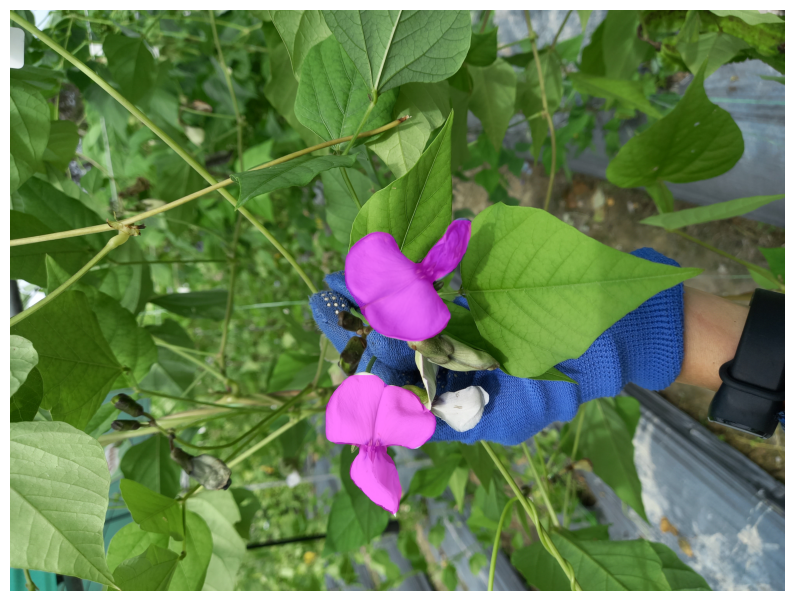

In [13]:
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from PIL import Image, ImageDraw, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import cv2


def get_trained_model(num_classes, model_path):
    model = maskrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def predict(model, image_path, device):
    img = Image.open(image_path).convert("RGB")
    img_tensor = F.to_tensor(img).unsqueeze(0).to(device)
    with torch.no_grad():
        prediction = model(img_tensor)

    return img, prediction

def visualize_prediction(img, prediction, threshold=0.5):
    pred_boxes = prediction[0]['boxes'].cpu().numpy()
    pred_scores = prediction[0]['scores'].cpu().numpy()
    pred_masks = prediction[0]['masks'].cpu().numpy()
    pred_labels = prediction[0]['labels'].cpu().numpy()

    img_with_masks = img.copy().convert("RGBA")
    img_array = np.array(img_with_masks)
    overlay = img_array.copy()

    for i, score in enumerate(pred_scores):
        if score > threshold:
            print(f"Predicted class: {pred_labels[i]}")
            mask = pred_masks[i][0]
            mask = (mask > 0.5).astype(np.uint8)  # Binarize the mask
            contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                contour = contour.squeeze(axis=1)
                for point in contour:
                    cv2.line(overlay, tuple(point), tuple(point), (255, 0, 255, 128), thickness=2)

            purple_mask = np.zeros_like(img_array)
            purple_mask[:, :, 0] = 255  # Red channel
            purple_mask[:, :, 2] = 255  # Blue channel
            purple_mask[:, :, 3] = 128  # Alpha channel
            mask_expanded = np.expand_dims(mask, axis=2)
            overlay = np.where(mask_expanded, purple_mask, overlay)

    combined = Image.alpha_composite(Image.fromarray(img_array), Image.fromarray(overlay))

    plt.figure(figsize=(10, 10))
    plt.imshow(combined)
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    model_path = "fin_mask_rcnn_model.pth"  # Replace with the actual model weight file path
    image_path = "Flower28.jpg"  # Replace with the actual image file path
    num_classes = 4  # Adjust the number of classes according to your dataset

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = get_trained_model(num_classes, model_path)
    model.to(device)

    img, prediction = predict(model, image_path, device)
    visualize_prediction(img, prediction)
